In [2]:
from __future__ import division
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_op
# from WindPy import *
from functools import reduce
import datetime

In [15]:
np.set_printoptions(precision=2)

### get_data

In [294]:
data=pd.read_excel('./data/value.xlsx')
data.set_index('Date',inplace=True)

In [216]:
data=pd.read_excel('./data/test1.xlsx')
data.set_index('Date',inplace=True)

In [219]:
rets.head()

,000001.SZ,600005.SH,000004.SZ,000005.SZ
Date,,,,
2016-01-06,0.011339,0.094491,0.012844,0.030976
2016-01-07,-0.052527,-0.103541,-0.105417,-0.104393
2016-01-08,0.016319,0.095310,0.006220,0.003621
2016-01-11,-0.032910,-0.039331,-0.105423,-0.105361
2016-01-12,0.004636,-0.034989,-0.011656,0.004008


In [300]:
tmp=data.loc[(data.index>'2015-01-01')&(data.index<'2017-01-01'),:]
rets=np.log(tmp/tmp.shift(1))
rets.dropna(inplace=True)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000


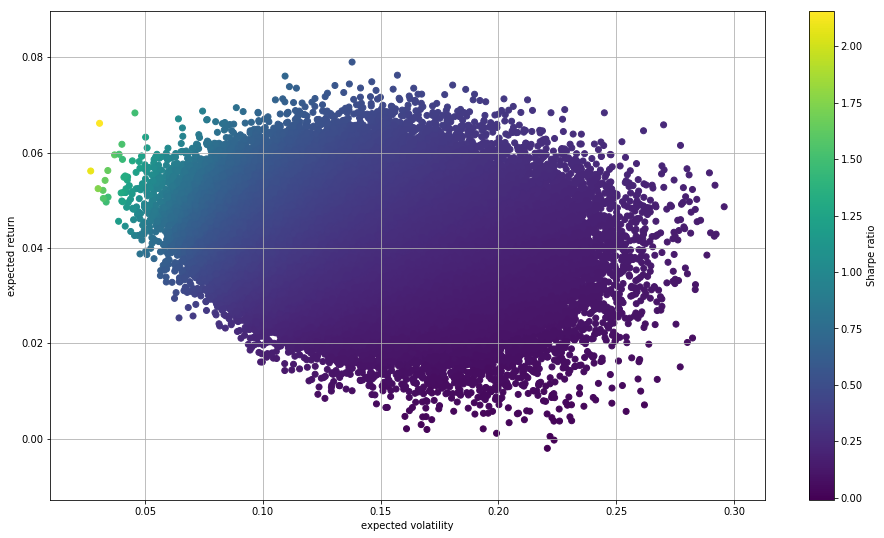

In [301]:
tmp_return = []
tmp_volatility = []
volatility_return={}

for p in range(100000):
    if p%10000==0:
        print(p)
    weights = np.random.random(8)
    weights /= np.sum(weights)
    expected_return = np.dot(weights.T, rets.mean())*252
    covariance_matrix = rets.cov()
    expected_volatility =np.sqrt(np.dot(np.dot(weights.T, covariance_matrix), weights)*252)
    tmp_return.append(expected_return)
    tmp_volatility.append(expected_volatility)
    try:
        volatility_return[expected_volatility].append(expected_return)
    except:
        volatility_return[expected_volatility]=[expected_return]
tmp_return = np.array(tmp_return)
tmp_volatility = np.array(tmp_volatility)

plt.figure(figsize=(16,9))
plt.scatter(tmp_volatility, tmp_return, c=tmp_return/tmp_volatility, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [305]:
std35_50=[]
std50_75=[]
std75_85=[]
for value in tmp_volatility:
    if value>0.02 and value<=0.05:
        std75_85.append(value)
    if value>0.05 and value<0.15:
        std50_75.append(value)
    else:
        std35_50.append(value)

std35_50=list(set(std35_50))
std50_75=list(set(std50_75))
std75_85=list(set(std75_85))

In [303]:
return_dic={}
for item in volatility_return.keys():
    try:
        return_dic[round(item,2)].extend(volatility_return[item])
    except:
        return_dic[round(item,2)]=volatility_return[item]

0.29586673192871926

### reference_weights

In [394]:
wage=10
l_wage=10*(1.04**30)
save=3
incre1=1+0.06
incre2=1+0.03
infla=1+0.03
use=15

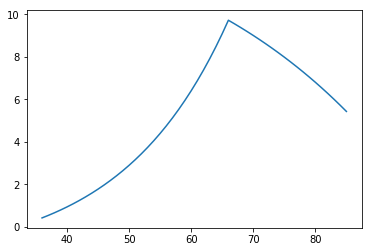

In [395]:
dic_returns={}
years=[]
rates=[]
refer_rates={}
dic_returns[35]=10
for year in range(36,86):
    if year<67:
        dic_returns[year]=dic_returns[year-1]*incre1+save
        rate=dic_returns[year]/l_wage
    else:
        dic_returns[year]=dic_returns[year-1]*incre2-use
        rate=dic_returns[year]/l_wage
    refer_rates[year]=rate
#     print(year,dic_returns[year])
    years.append(year)
    rates.append(rate)
plt.plot(years,rates)

### find_weights

In [362]:
def fun_expected_returns(weights):
    expected_returns=[]
    weights=np.round(weights,2)
    x1=weights[0]
    x2=weights[1]
    x3=weights[2]
    for year in range(35,50):
        a=np.random.randint(len(return_dic[x1]))
        expected_returns.append(return_dic[x1][a])
    for year in range(50,75):
        a=np.random.randint(len(return_dic[x2]))
        expected_returns.append(return_dic[x2][a])
    for year in range(75,86):
        a=np.random.randint(len(return_dic[x3]))
        expected_returns.append(return_dic[x3][a])
    return expected_returns


In [391]:
def fun_utility_accumulation(weights):
    min_utility_list=[]
    
    for i in range(1000):
        expected_returns=fun_expected_returns(weights)

        dic_returns1={}
        utility_list=[]
        dic_returns1[35]=10
        for year in range(35,85):
            if year<66:
                ex_wealth=dic_returns1[year]*(1+expected_returns[year-35])+save
            else:
                ex_wealth=dic_returns1[year]*(1+expected_returns[year-35])-use
            ex_rate=ex_wealth/l_wage
            if ex_rate>refer_rates[year+1]:
                utility=ex_rate-refer_rates[year+1]
            else:
                utility=2*(ex_rate-refer_rates[year+1])
            utility_list.append(utility)
            dic_returns1[year+1]=ex_wealth
            
        min_utility_list.append(np.sum(utility_list))
#     print(weights,np.min(min_utility_list))
    return np.min(min_utility_list)

In [363]:
def get_weights_accumulation():
    constraints = ({'type':'eq', 'fun':lambda x: np.sum(x)-1.},
             )
#     n=np.random.randint(len(std35_50))
#     x1=std35_50[n]
    
#     n=np.random.randint(len(std50_75))
#     x2=std50_75[n]
    
#     n=np.random.randint(len(std75_85))
#     x3=std75_85[n]
    weights=np.random.random(3)
    
#     weights=np.array([x1,x2,x3])
    bounds = tuple([(0.03,0.3),(0.03,0.3),(0.03,0.3)])

    initial_guess = weights
    opts = sci_op.minimize(fun=fun_utility_accumulation,
                           x0=initial_guess,
                           method='SLSQP',bounds=bounds,
                           )
        
    return opts['x']

In [396]:
key_list=list(return_dic.keys())
results=np.zeros((10000,4))
for j in range(5000):
    if j%1000==0:
        print(j)
    weights=[]
    for i in range(3):
        a=np.random.randint(len(key_list))
        weights.append(key_list[a])
    utility=fun_utility_accumulation(weights)
    weights.append(utility)
    results[j]=weights



0
1000
2000
3000
4000


In [397]:
tmp=pd.DataFrame(results,columns=['age1','age2','age3','utility'])

In [398]:
tmp=tmp.loc[tmp.age1>0.0,:]

In [404]:
tmp.sort_values(by=['age1','age2','age3','utility'],ascending=False).to_csv('result.csv')

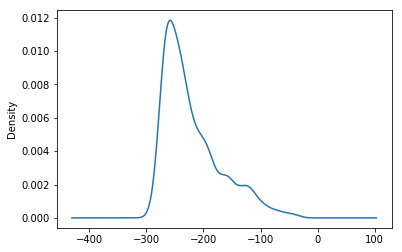

In [405]:
tmp.utility.plot(kind='kde')

In [169]:
np.min([1,2,3])

1

In [185]:
max(volatility_return.keys())

0.44